## Image plots for the proposals with the no-background classes and their ground truth boxes

## Training and Validation curves of the total loss, the loss of the classifier and the loss of the regressor of the Box Head
![Training Plot](plots/training_plot.png)
![Validation Plot](plots/val_plot.png)

Please note that the plots start from epoch 0, so when referring to 'epoch 14' on the plot, it actually corresponds to epoch 15 in the training process

## Image plots of the regressed boxes after the postprocessing
During the training process, we saved model checkpoints at epoch 15 and at the end of training, which is epoch 30. We obtained the following Average Precision (AP) values for the test set using these two models:

**Epoch 15:**
- The Average Precision for the 'Vehicles' class is: 0.923
- The Average Precision for the 'People' class is: 0.970
- The Average Precision for the 'Animals' class is: 0.937
- The mAP is 0.943

**Epoch 30:**
- The Average Precision for the 'Vehicles' class is: 0.931
- The Average Precision for the 'People' class is: 0.969
- The Average Precision for the 'Animals' class is: 0.94
- The mAP is 0.946

## Image plots of the regressed boxes after the postprocessing
![postprocessing_results](plots/postprocessing_results.png)
![postprocessing_results](plots/postprocessing_results_2.png)

In [1]:
from faster_rcnn_datamodule import DataModule
from BoxHead import BoxHead
from utils import non_max_suppression, output_decoding, average_precision
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torchvision.models.detection.image_list import ImageList

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
keep_topK = 200
keep_num_preNMS = 20

In [4]:
def postprocess_bboxes(img_id, class_logits, box_preds):
    class_prob = F.softmax(class_logits[img_id], dim=1)
    max_probs, max_classes = torch.max(class_prob[:, 1:], dim=1)
    keep_indices = torch.where(max_probs > 0.5)
    
    start_indices = max_classes[keep_indices] * 4
    range_indices = torch.arange(4).to(start_indices.device)
    start_indices = start_indices.unsqueeze(1)
    indices = start_indices + range_indices
    
    regressed_boxes_t = torch.gather(box_preds[img_id][keep_indices], 1, indices)
    bboxes = output_decoding(regressed_boxes_t, proposals[img_id][keep_indices])

    bboxes = torch.column_stack([max_classes[keep_indices].unsqueeze(1), max_probs[keep_indices].unsqueeze(1), bboxes])
    
    sorted_indices = torch.argsort(bboxes[:, 1], descending=True)
    
    return bboxes[sorted_indices]

In [5]:
def postprocess_img(img_id, class_logits, box_preds):
    bboxes = postprocess_bboxes(img_id, class_logits, box_preds)
    pre_nms_bboxes = bboxes[:keep_num_preNMS]
    bboxes = non_max_suppression(pre_nms_bboxes)
    bboxes = bboxes.detach().cpu().numpy()
    return bboxes

In [6]:
imgs_path = '../partA/data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = '../partA/data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = '../partA/data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = '../partA/data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
datamodule = DataModule(paths) 
     
box_head = BoxHead.load_from_checkpoint('/home/ny0221/cis680/hw4/partB/faster_rcnn/456mwe1b/checkpoints/epoch_29.ckpt')

/home/ny0221/anaconda3/envs/cis680/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ny0221/anaconda3/envs/cis680/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
datamodule.setup("test")
test_loader = datamodule.test_dataloader()
test_iterator = iter(test_loader)
batch = next(test_iterator)
imgs, labels, bboxes, indices = batch
imgs = imgs.to(device)

/home/ny0221/anaconda3/envs/cis680/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [11]:
all_preds = []
all_targets = []
img_idx = 0
for batch in test_loader:
    imgs, labels, bboxes, indices = batch
    imgs = imgs.to(device)
    
    batch_size = len(imgs)

    backout = box_head.backbone(imgs)

    im_lis = ImageList(imgs, [(800, 1088)]*imgs.shape[0])
    rpnout = box_head.rpn(im_lis, backout)

    # A list of proposal tensors: list:len(bz){(keep_topK,4)}
    proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
    # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
    fpn_feat_list= list(backout.values())
           
    proposals = box_head.sort_proposals(proposals)
                
    feature_vectors = box_head.MultiScaleRoiAlign(fpn_feat_list,proposals, P=7)
    class_logits, box_preds = box_head(feature_vectors)

    class_logits = torch.split(class_logits, keep_topK)
    box_preds = torch.split(box_preds, keep_topK)
    
    for i in range(batch_size): 
        preds = postprocess_img(i, class_logits, box_preds)
        if len(preds) > 0:
            preds = np.column_stack([np.full((len(preds), 1), img_idx), preds])
            all_preds.append(preds)
        if len(bboxes[i]) > 0:
            all_targets.append(np.column_stack([np.full((len(bboxes[i]), 1), img_idx), labels[i].numpy().reshape(-1,1), bboxes[i].numpy()]))
        img_idx += 1

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

In [27]:
test_iterator = iter(test_loader)
for i in range(8):
    batch = next(test_iterator)

imgs, labels, bboxes, indices = batch
imgs = imgs.to(device)
    
batch_size = len(imgs)

backout = box_head.backbone(imgs)

im_lis = ImageList(imgs, [(800, 1088)]*imgs.shape[0])
rpnout = box_head.rpn(im_lis, backout)

# A list of proposal tensors: list:len(bz){(keep_topK,4)}
proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
# A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
fpn_feat_list= list(backout.values())
           
proposals = box_head.sort_proposals(proposals)
                
feature_vectors = box_head.MultiScaleRoiAlign(fpn_feat_list,proposals, P=7)
class_logits, box_preds = box_head(feature_vectors)

class_logits = torch.split(class_logits, keep_topK)
box_preds = torch.split(box_preds, keep_topK)
    

In [28]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
imgs_for_viz = imgs.cpu().numpy()
imgs_for_viz = np.moveaxis(imgs_for_viz, 1, -1) 
# denormalize the image
imgs_for_viz = (imgs_for_viz * std) + mean
imgs_for_viz = np.clip(imgs_for_viz, 0, 1)

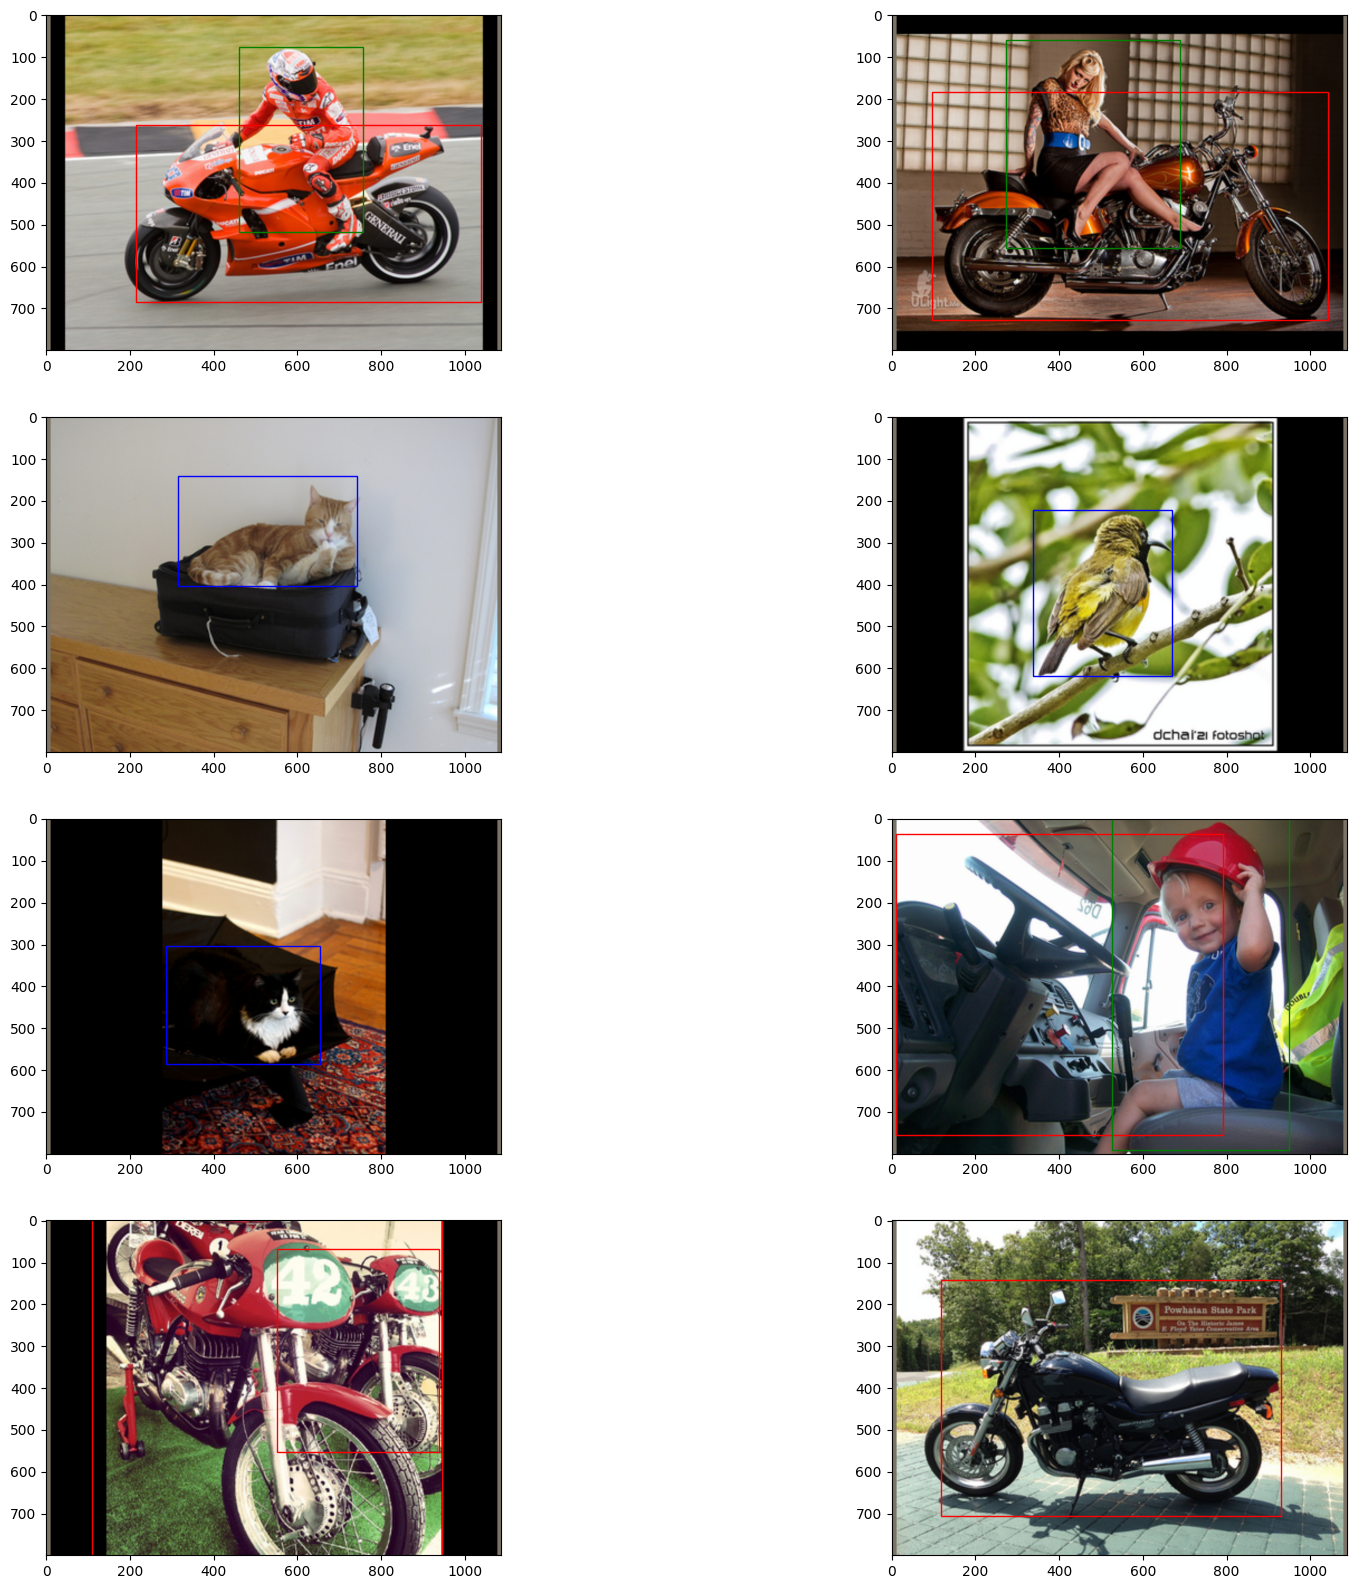

In [29]:
colors = ["red", "green", "blue"]
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

flat_axes = axes.ravel() 

for img_id, ax in enumerate(flat_axes):
    ax.imshow(imgs_for_viz[img_id])

    bboxes = postprocess_img(img_id, class_logits, box_preds)
    
    for bbox in bboxes:
        clas = int(bbox[0])
        x, y = bbox[2], bbox[3]
        width = bbox[4] - bbox[2]
        height = bbox[5] - bbox[3]
        rect = Rectangle((x, y), width, height, linewidth=1, edgecolor=colors[clas], facecolor='none')
        ax.add_patch(rect)
plt.savefig('postprocessing_results.png')

In [ ]:
recalls, precisions = precision_recall_curve(predicted_bboxes, gt_bboxes, 0)
class_name = "Pedestrian" 

plt.figure(figsize=(5, 3))
plt.plot(recalls, precisions, '-o', label=f'Precision-Recall Curve for {class_name}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for {class_name}')
plt.legend()
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.show()